# Lecture 3a - Spurious Waffle Houses

McElreath's lectures for the whole book are available here: https://github.com/rmcelreath/statrethinking_winter2019

An R/Stan repo of code is available here: https://vincentarelbundock.github.io/rethinking2/

An excellent port to Python/PyMC3 Code is available here: https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3

You are encouraged to work through both of these versions to re-enforce what we're doing in class.

In [7]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp 
import random as rd
import pymc as pm
from matplotlib import pyplot as plt

## Waffle Houses

Let's import the Waffe House devorce data:

In [8]:
# Import data
ddata = pd.read_csv('WaffleDivorce.csv',';')
# Display top 5 rows
ddata.head()

/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [9]:
# Table of descriptive statistics
ddata.describe().T

,count,mean,std,min,25%,50%,75%,max
Population,50.0,6.119600,6.876156,0.56,1.6350,4.435,6.6775,37.25
MedianAgeMarriage,50.0,26.054000,1.243630,23.20,25.3250,25.900,26.7500,29.70
Marriage,50.0,20.114000,3.797905,13.50,17.1250,19.700,22.1000,30.70
Marriage SE,50.0,1.399400,0.796975,0.39,0.8100,1.185,1.7675,3.92
Divorce,50.0,9.688000,1.820814,6.10,8.3000,9.750,10.9000,13.50
Divorce SE,50.0,0.961800,0.525367,0.24,0.5725,0.795,1.2575,2.50
WaffleHouses,50.0,32.340000,65.789587,0.00,0.0000,1.000,39.7500,381.00
South,50.0,0.280000,0.453557,0.00,0.0000,0.000,1.0000,1.00
Slaves1860,50.0,79378.340000,149730.921149,0.00,0.0000,0.000,80828.0000,490865.00
Population1860,50.0,628729.280000,781312.662599,0.00,43321.0000,407722.000,920977.0000,3880735.00


So not unintense data to look at, but let's start with divorce and Waffle Houses

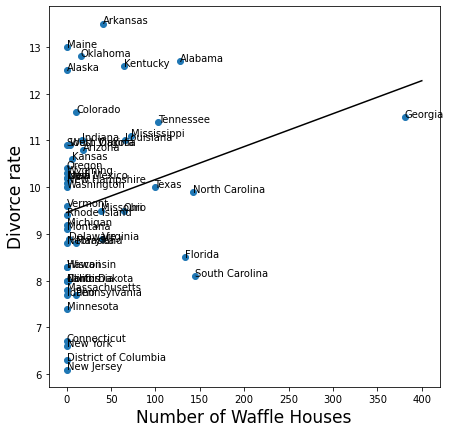

In [10]:
plt.figure(figsize=(7,7))
plt.scatter(ddata.WaffleHouses,ddata.Divorce)
[plt.annotate(txt, (ddata.WaffleHouses[i], ddata.Divorce[i])) for i, txt in enumerate(ddata.Location)]
b1,b0 = np.polyfit(ddata.WaffleHouses,ddata.Divorce, 1)
xnew = np.linspace(0,400,100)
plt.plot(xnew,b0+b1*xnew,c='black')
plt.xlabel('Number of Waffle Houses', fontsize=17)
plt.ylabel('Divorce rate', fontsize=17)
plt.savefig('WaffleDivorce.jpg');

Or is divorce rate a product of marriage rate?

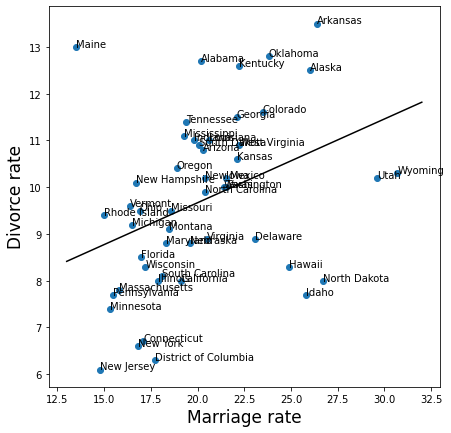

In [11]:
plt.figure(figsize=(7,7))
plt.scatter(ddata.Marriage,ddata.Divorce)
[plt.annotate(txt, (ddata.Marriage[i], ddata.Divorce[i])) for i, txt in enumerate(ddata.Location)]
b1,b0 = np.polyfit(ddata.Marriage,ddata.Divorce, 1)
xnew = np.linspace(13,32,100)
plt.plot(xnew,b0+b1*xnew,c='black')
plt.xlabel('Marriage rate', fontsize=17)
plt.ylabel('Divorce rate', fontsize=17)
plt.savefig('WaffleMarriage.jpg');

Or age at marriage?

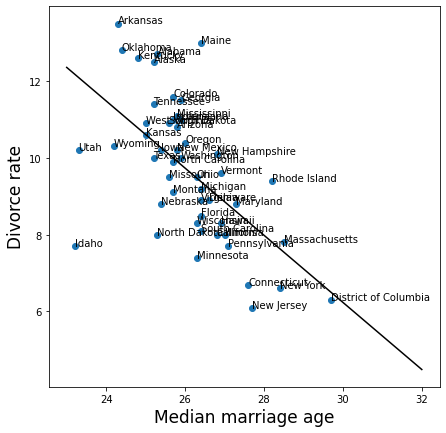

In [12]:
plt.figure(figsize=(7,7))
plt.scatter(ddata.MedianAgeMarriage,ddata.Divorce)
[plt.annotate(txt, (ddata.MedianAgeMarriage[i], ddata.Divorce[i])) for i, txt in enumerate(ddata.Location)]
b1,b0 = np.polyfit(ddata.MedianAgeMarriage,ddata.Divorce, 1)
xnew = np.linspace(23,32,100)
plt.plot(xnew,b0+b1*xnew,c='black')
plt.xlabel('Median marriage age', fontsize=17)
plt.ylabel('Divorce rate', fontsize=17)
plt.savefig('WaffleAge.jpg');

And what does the South have to do with all this? Well with the assertion of a causal model we can take a look and see. For example, if we assert:

A->M->D
A->D

Then we can look and see what the affect of marriage rate (M) is on divorce (D), given that we know the median age (A). To do this we need a statistcal model to help evaluate this DAG.

$$
D_i \sim N(\mu_i,\sigma)\\
\mu_i = \beta_0+\beta_M M_i+\beta_A A_i
$$

There is nothing magic here - we've all done multiple regression before - but what is new is our causal assertion. Weird, that what we assert and assume changes things eh? But you should get very comfortable with this idea because it turns out it lies at the core of scientific enquiry - as Popper argued, causality is built consenually. 

First we should standardize variables:


In [13]:
def stdize(x):
    return (x-np.mean(x))/np.std(x)

In [14]:
A = stdize(ddata.MedianAgeMarriage.values)
M = stdize(ddata.Marriage.values)
D = stdize(ddata.Divorce.values)

With covariates in hand we can do some prior predictive simulation to see what priors might look like in terms of possible lines:

In [15]:
# Number of samples
nsamp = 100
# Intercept
β0_ = np.random.normal(0, .2, nsamp)
# Marriage rate slope
βm_ = np.random.normal(0, .5, nsamp)
# Marriage age slope
βa_ = np.random.normal(0, .5, nsamp)

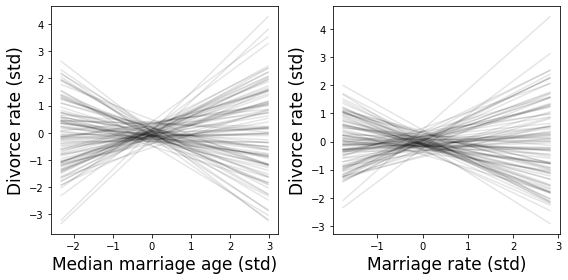

In [16]:
_, ax = plt.subplots(1,2, figsize=(8,4))

# Grab range of marriage ages to plot over
A_ = np.linspace(min(A),max(A),50)
# Plot resulting lines given sample values for β0 and βa, using a list comprehension
[ax[0].plot(A_, b0+b1*A_, c='black', alpha=0.1) for b0,b1 in zip(β0_,βa_)]
# Make it look nice
ax[0].set_xlabel('Median marriage age (std)', fontsize=17)
ax[0].set_ylabel('Divorce rate (std)', fontsize=17)



# Grab range of marriage rates to plot over
M_ = np.linspace(min(M),max(M),50)
# Plot resulting lines given sample values for β0 and βm, using a list comprehension
[ax[1].plot(M_, b0+b1*M_, c='black', alpha=0.1) for b0,b1 in zip(β0_,βm_)]
# Make it look nice
ax[1].set_xlabel('Marriage rate (std)', fontsize=17)
ax[1].set_ylabel('Divorce rate (std)', fontsize=17)
plt.tight_layout();

Next, we can bulid a NUTS model in PyMC3:

In [17]:
# Causal model

# Bayesian PyMC3
with pm.Model() as divorce:
    # Priors
    β0 = pm.Normal('Intercept', 0, .2)
    βa = pm.Normal('Marriage age', 0, .5)
    βm = pm.Normal('Marriage rate', 0, .5)
    σ = pm.Exponential('Sigma', 1)
    
    # Linear model
    μ_ = pm.Deterministic('Mu', β0+βa*A+βm*M)
    
    # Link function
    μ = μ_*1
    
    # Likelihood
    yi = pm.Normal('yi',μ, σ, observed=D)

In [18]:
# Run sampler
with divorce:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Marriage age, Marriage rate, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [30]:
pm.summary(trace, var_names=['Intercept','Marriage age']).T.to_csv('oop.csv')

In [29]:
tmp

/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


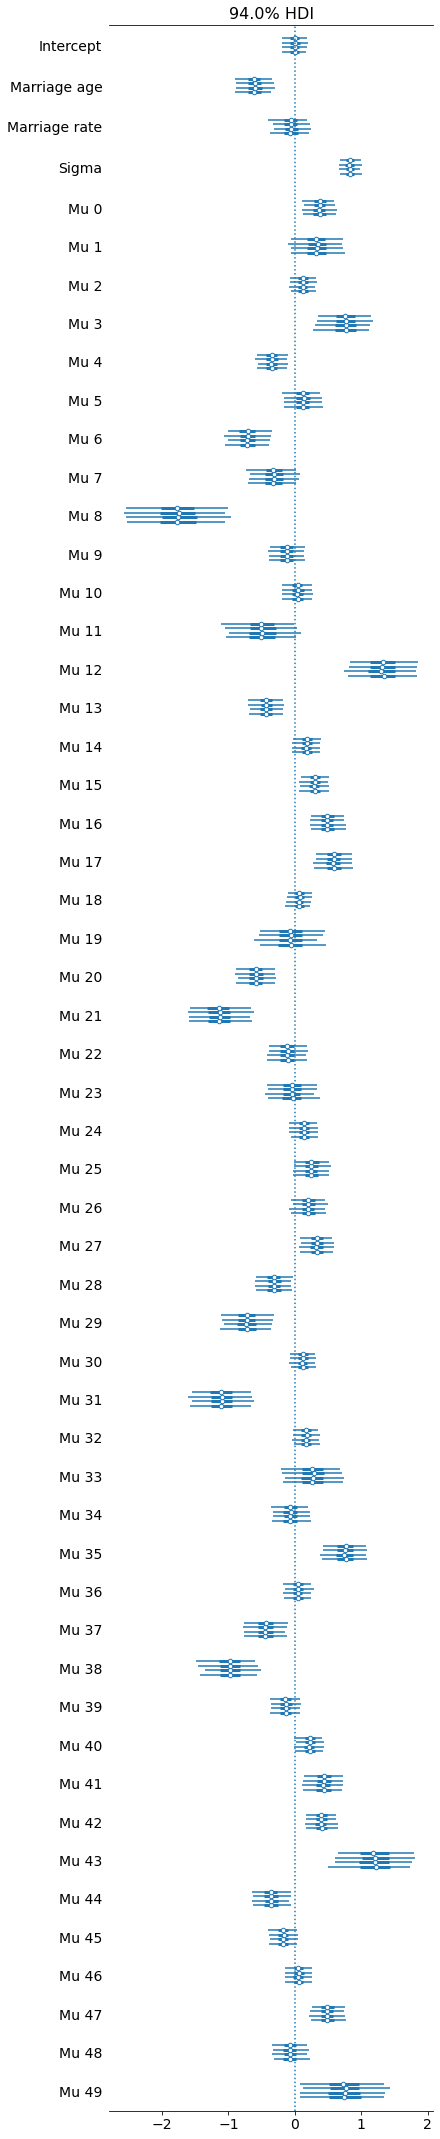

In [14]:
pm.plot_forest(trace, ridgeplot_overlap=3)
plt.axvline(0,linestyle=':');

In [15]:
# Bayesian PyMC3
with pm.Model() as divorce_m:
    # Priors
    β0 = pm.Normal('Intercept', 0, .2)
    βm = pm.Normal('Marriage rate', 0, .5)
    σ = pm.Exponential('Sigma', 1)
    
    # Linear model
    μ_ = pm.Deterministic('Mu', β0+βm*M)
    
    # Link function
    μ = μ_*1
    
    # Likelihood
    yi = pm.Normal('yi',μ, σ, observed=D)

In [16]:
# Bayesian PyMC3
with pm.Model() as divorce_a:
    # Priors
    β0 = pm.Normal('Intercept', 0, .2)
    βa = pm.Normal('Marriage age', 0, .5)
    σ = pm.Exponential('Sigma', 1)
    
    # Linear model
    μ_ = pm.Deterministic('Mu', β0+βa*A)
    
    # Link function
    μ = μ_*1
    
    # Likelihood
    yi = pm.Normal('yi',μ, σ, observed=D)

In [17]:
# Run samplers
with divorce_m:
    trace_m = pm.sample(1000)
with divorce_a:
    trace_a = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Sigma, Marriage rate, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Sigma, Marriage age, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


In [18]:
import arviz as az

''

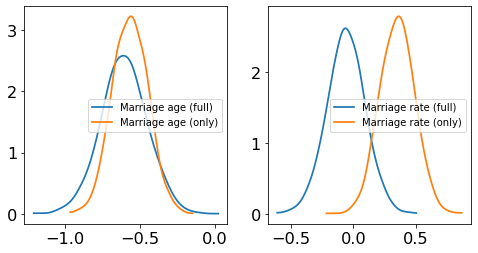

In [19]:
_, ax = plt.subplots(1,2, figsize=(8,4))

v_ = 'Marriage age'
ax_ = 0
az.plot_dist(trace[v_],ax=ax[ax_], label=v_+' (full)')
az.plot_dist(trace_a[v_],ax=ax[ax_], label=v_+' (only)')


v_ = 'Marriage rate'
ax_ = 1
az.plot_dist(trace[v_],ax=ax[ax_], label=v_+' (full)')
az.plot_dist(trace_m[v_],ax=ax[ax_], label=v_+' (only)')
;

# Plotting

Among the most - I'll say **the most** - important checks on your models is to plot the model and the data together. It is critical that you see things the way the model sees things, otherwise it is difficult to know how well you're doing in fitting these things. Three options are:

    1. Predictor residual plots
    2. Posterior prediction plots
    3. Counterfactual plots
    
Each has their own value and can tell us something about how our model is doing.

## 1. Predictor residual plots

There's an awful legacy in Biology of modelling the residuals of another model. It's awful because it's wrong, and you should never do it. It's wrong because it doesn't get the unceratinties right, prioritizing variation in the first analysis and hiding it in the second. This leads to biased estiamtes, possibly for both models, but certainly for the second. But there is some utility in seeing what information remains in one predictor when you already have information about the other (which is what multiple regression does). 

To do this we need to build individual models where we regress one predictor on the other, which will give us the marginal benefit of the other predictor conditional on knowing one of them.

So for the divorce case, we have two models:

In [20]:
# Bayesian PyMC3
with pm.Model() as m_a:
    # Priors
    β0 = pm.Normal('Intercept', 0, .2)
    βm = pm.Normal('Marriage rate', 0, .5)
    σ = pm.Exponential('Sigma', 1)
    
    # Linear model
    μ_ = pm.Deterministic('Mu', β0+βm*M)
    
    # Link function
    μ = μ_*1
    
    # Likelihood
    yi = pm.Normal('yi',μ, σ, observed=A)

In [21]:
# Bayesian PyMC3
with pm.Model() as a_m:
    # Priors
    β0 = pm.Normal('Intercept', 0, .2)
    βm = pm.Normal('Marriage age', 0, .5)
    σ = pm.Exponential('Sigma', 1)
    
    # Linear model
    μ_ = pm.Deterministic('Mu', β0+βm*A)
    
    # Link function
    μ = μ_*1
    
    # Likelihood
    yi = pm.Normal('yi',μ, σ, observed=M)

In [22]:
# Run samplers
with a_m:
    trace_m = pm.sample(1000)
with m_a:
    trace_a = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Sigma, Marriage age, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.8817918808056268, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Sigma, Marriage rate, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


In [23]:
# Get residuals for the other predictor
m_pred = trace_m['Mu'].mean(0)
residuals_m = M - m_pred

a_pred = trace_a['Mu'].mean(0)
residuals_a = A - a_pred

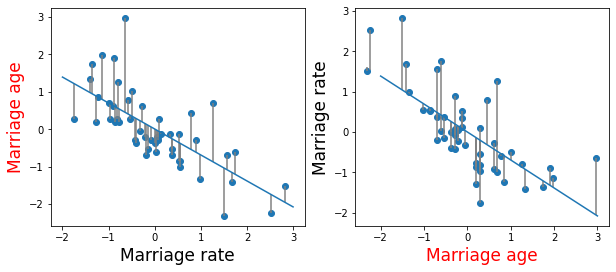

In [24]:
_, ax = plt.subplots(1,2, figsize=(10,4))

xnew = np.linspace(-2,3,100)

v_ = 'Marriage rate'
ax_ = 0
ax[ax_].scatter(M,A)
ax[ax_].plot(xnew,np.median(trace_a['Intercept'])+np.median(trace_a[v_])*xnew)
ax[ax_].set_ylabel('Marriage age', fontsize=17,c='red')
ax[ax_].set_xlabel(v_, fontsize=17)
ax[ax_].vlines(M, a_pred, a_pred + residuals_a, colors='grey')

v_ = 'Marriage age'
ax_ = 1
ax[ax_].scatter(A,M)
ax[ax_].plot(xnew,np.median(trace_m['Intercept'])+np.median(trace_m[v_])*xnew)
ax[ax_].set_ylabel('Marriage rate', fontsize=17)
ax[ax_].set_xlabel(v_, fontsize=17,c='red')
ax[ax_].vlines(A, m_pred, m_pred + residuals_m, colors='grey');

What's seemingly bonkers, is that we now have the residuals for each parameter, we can plot them against divorce to see how the **full model** actually sees these things inside their guts:

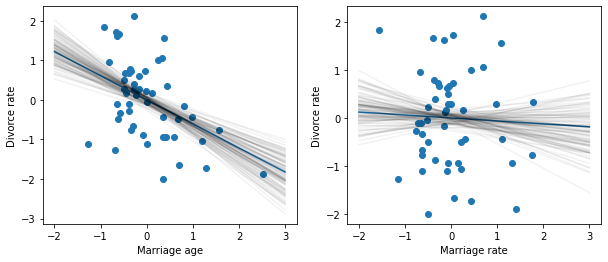

In [25]:
_, ax = plt.subplots(1,2, figsize=(10,4))

xnew = np.linspace(-2,3,100)

v_ = 'Marriage age'
ax_ = 0
ax[ax_].scatter(residuals_a,D)
ax[ax_].plot(xnew,np.median(trace['Intercept'])+np.median(trace[v_])*xnew)
[ax[ax_].plot(xnew, trace['Intercept'][i]+trace[v_][i]*xnew, alpha=0.05, c='black') for i in range(100)]
ax[ax_].set_ylabel('Divorce rate')
ax[ax_].set_xlabel(v_)

v_ = 'Marriage rate'
ax_ = 1
ax[ax_].scatter(residuals_m,D)
ax[ax_].plot(xnew,np.median(trace['Intercept'])+np.median(trace[v_])*xnew)
[ax[ax_].plot(xnew, trace['Intercept'][i]+trace[v_][i]*xnew, alpha=0.05, c='black') for i in range(100)]
ax[ax_].set_ylabel('Divorce rate')
ax[ax_].set_xlabel(v_);


So conditional on knowing marriage rate, marriage age still tells us something useful about divorce, but conditional on knowing marriage age, marriage rate tells us very little. Hence the difference in parameter estimates, with marriage age having a way bigger effect size. 

Incidentally, while we have these residuals, let's take a look at their distribtuion and what they mean:

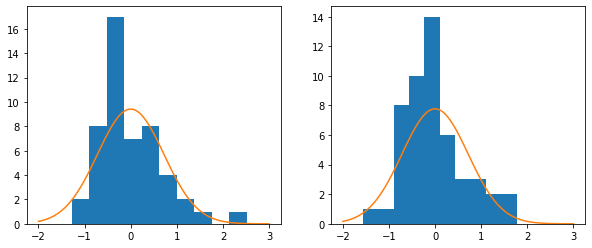

In [26]:
_, ax = plt.subplots(1,2, figsize=(10,4))

tmp = ax[0].hist(residuals_a)
ax[0].plot(xnew,sp.stats.norm.pdf(xnew,0,trace_m['Sigma'].mean(0))*max(tmp[0]))

tmp = ax[1].hist(residuals_m)
ax[1].plot(xnew,sp.stats.norm.pdf(xnew,0,trace_a['Sigma'].mean(0))*max(tmp[0]));

The distribution of the residuals is the error distribution (`Sigma`) for the linear model - i.e. `Sigma` describes the magnitude of the deviations from the regression line. 

## 2. Posterior prediction plots

Another important question is - how well is our model capturing the observed data? Are our predictions about each observation any good? Having used MCMC for our inference (and stored the values using a `pm.Determinisitc` node), we can just grab the observed and expected values and plot them:

In [27]:
# Create data frame of transposed traces for each state observation
PostObs = pd.DataFrame(trace['Mu'], columns=ddata.Location)
PostObs

Location,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,0.227984,0.043424,-0.002632,0.435544,-0.408373,-0.084137,-0.691744,-0.476257,-1.667466,-0.143815,...,0.095956,0.305024,0.221787,0.762013,-0.346686,-0.282542,-0.091562,0.284703,-0.106412,0.310439
1,0.435008,0.484683,0.158539,0.981768,-0.393048,0.210724,-0.833313,-0.286360,-1.994657,-0.169922,...,0.269281,0.491055,0.489028,1.531423,-0.445716,-0.173301,0.102203,0.598901,-0.114841,1.032891
2,0.414394,0.378677,0.188789,0.776709,-0.242975,0.189185,-0.573941,-0.208847,-1.523981,-0.034434,...,0.281254,0.470349,0.441181,1.180694,-0.250316,-0.083048,0.128667,0.521144,0.007632,0.761827
3,0.150136,0.285021,-0.037477,0.632429,-0.436126,0.053912,-0.772442,-0.293496,-1.557410,-0.319827,...,0.034892,0.174611,0.209741,1.064535,-0.519151,-0.261276,-0.056933,0.297166,-0.278624,0.742220
4,0.141689,0.463445,-0.004426,0.755605,-0.367025,0.186645,-0.709378,-0.105514,-1.314014,-0.351665,...,0.045978,0.131707,0.237260,1.218731,-0.532964,-0.175743,0.020636,0.332901,-0.311384,1.001966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.412725,0.482290,0.171448,0.918713,-0.316234,0.231493,-0.710186,-0.204930,-1.722893,-0.130608,...,0.267373,0.458125,0.465814,1.413717,-0.374448,-0.117793,0.127146,0.565034,-0.081547,0.982786
3996,0.324760,0.283765,0.059627,0.751633,-0.448021,0.060635,-0.837338,-0.407234,-1.953802,-0.203282,...,0.168265,0.390387,0.356462,1.226972,-0.457106,-0.259824,-0.010847,0.450560,-0.153810,0.734871
3997,0.442584,0.392256,0.179991,0.854675,-0.320456,0.175608,-0.702435,-0.286810,-1.808508,-0.074685,...,0.287856,0.508887,0.471777,1.319779,-0.324908,-0.136535,0.108387,0.563738,-0.026054,0.830853
3998,0.343450,0.277480,0.058233,0.778611,-0.482609,0.047218,-0.893301,-0.453913,-2.095016,-0.211740,...,0.175702,0.416980,0.372594,1.277181,-0.482162,-0.285717,-0.021637,0.471039,-0.159347,0.744346


In [28]:
# Calculate expected y values and UI's 
y = PostObs.median(0).values
y_l95 = np.percentile(PostObs,2.5,axis=0)
y_u95 = np.percentile(PostObs,97.5,axis=0)

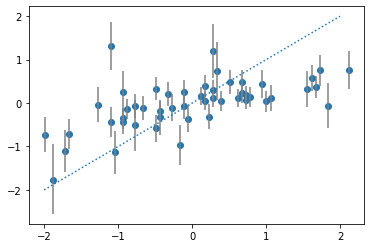

In [29]:
# Plot expected vs observed
plt.vlines(D, y_l95, y_u95, colors='grey')
plt.scatter(D,y)
plt.plot((-2,2),(-2,2),linestyle=":");

So we can see that our model underpredicts high divorce rates (right side) and overpredicts low devorce rates (left side) but that is to be expected, it is a normal model after all an predictions tend to shrink toward the overall average. 

But it does look like there are some outlying values, let's label a few

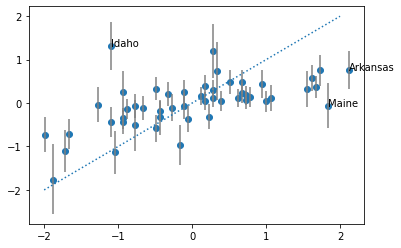

In [30]:
# Plot expected vs observed
plt.vlines(D, y_l95, y_u95, colors='grey')
plt.scatter(D,y)
plt.plot((-2,2),(-2,2),linestyle=":");


# Label states that are >x SD off
x = 1.3
[plt.text(D[i],y[i],ddata.Location.values[i]) for i in np.arange(0,len(ddata.Location.values))[abs(D-y)>x]];

## 3. Counterfactual plots

Counterfactuals are frequently brought up in statistical circles, and especially in economics, as a device to imagine what would happen if something else had happened in our data. In the case of counterfactual plots, they show us what happens if we manipulate one variable while keeping the others constant. 

If we return to the causal model where median marriage age influences divorce rate both directly and indirectly via marriage rate, we can develop a counterfactual plot by simulating from our `divorce` and `a_m` models above.

In [31]:
# Divorce model trace
pm.summary(trace,var_names=['Intercept','Marriage rate','Marriage age','Sigma'])

/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.001,0.101,-0.192,0.186,0.002,0.002,3299.0,1857.0,3302.0,2579.0,1.0
Marriage rate,-0.061,0.153,-0.336,0.239,0.003,0.002,2615.0,2429.0,2610.0,2458.0,1.0
Marriage age,-0.608,0.152,-0.910,-0.336,0.003,0.002,2516.0,2481.0,2518.0,2692.0,1.0
Sigma,0.833,0.091,0.677,1.007,0.002,0.001,2485.0,2485.0,2399.0,1997.0,1.0


In [32]:
# a_m model trace
pm.summary(trace_m, var_names=['Intercept','Marriage age','Sigma'])

/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,0.001,0.091,-0.172,0.166,0.001,0.001,5522.0,2017.0,5563.0,3199.0,1.0
Marriage age,-0.691,0.102,-0.880,-0.503,0.001,0.001,4991.0,4974.0,4992.0,2961.0,1.0
Sigma,0.720,0.077,0.588,0.874,0.001,0.001,4257.0,4086.0,4469.0,2786.0,1.0


With these values in place, we can see what the predicted change in divorce rate is across the full range of changes in median marriage age. To do this, we first choose the range of marriage ages:

In [33]:
# Marriage age prediction range
nsim = 100
A_new = np.linspace(min(A),max(A),nsim)

Next we calculate the expected effect of marriage age on marriage rate:

In [34]:
# Marriage rates given marriage age range
M_new = np.median(trace_m['Intercept'])+np.median(trace_m['Marriage age'])*A_new

And finally we simulate from the full `divorce` model, given our new (counterfactual) covariate values:


In [35]:
D_new = np.median(trace['Intercept'])+np.median(trace['Marriage age'])*A_new+np.median(trace['Marriage rate'])*M_new

''

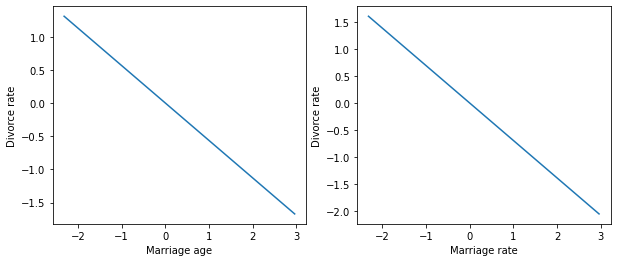

In [36]:
_, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].plot(A_new,D_new)
ax[0].set_xlabel('Marriage age')
ax[0].set_ylabel('Divorce rate')


ax[1].plot(A_new,M_new)
ax[1].set_xlabel('Marriage rate')
ax[1].set_ylabel('Divorce rate')
;

# Masked relationships

One of the many (many, many,...) pitfalls of statistical models is the presence of masked relationships - variables that counteract each other so they each appear to have no particular relationship. The primate milk data has just such a case.

In [37]:
# Import data
mdata = pd.read_csv('milk.csv', sep=';')
# Drop rows where neocortex percent is nan
mdata = mdata[mdata['neocortex.perc'].notna()]
# Add log(mass) column
mdata['log(mass)'] = np.log(mdata.mass.values)
mdata.head()

FileNotFoundError: [Errno 2] File milk.csv does not exist: 'milk.csv'

If we take a look at the bivariate relationships among variables, it seems there's not too much going on beyond the relationship between 

In [ ]:
g = sns.PairGrid(mdata, vars=['kcal.per.g','log(mass)','neocortex.perc'])
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2);

Yet if we run the full model for the relationship between log(mass) and neocortex.conc on kcal.per.g, we get a surprise:

In [ ]:
# Grab variables of interest
logMass = stdize(mdata['log(mass)'].values)
neocorp = stdize(mdata['neocortex.perc'].values)
kcal = stdize(mdata['kcal.per.g'])

In [ ]:
# Bayesian PyMC3
with pm.Model() as milker:
    # Priors
    β0 = pm.Normal('Intercept', 0, .2)
    β1 = pm.Normal('log(mass)', 0, .5)
    β2 = pm.Normal('neocortex_perc', 0, .5)
    σ = pm.Exponential('Sigma', 1)
    
    # Linear model
    μ_ = β0+β1*logMass+β2*neocorp
    
    # Link function
    μ = μ_*1
    
    # Likelihood
    yi = pm.Normal('yi',μ, σ, observed=kcal)

In [ ]:
with milker:
    trace_milk = pm.sample(1000)

In [ ]:
pm.summary(trace_milk)

What's this now? Both log(mass) and percent neocortex do not span zero, meaning they have strong relationships in the data. This can happen and is due to some unknown variable having synnergistic effects on both variables, but in different directions. Because they both happen they appear to not have any effect in a bivariate plot, but when both are present, their actual effects are revealed. Knowing that it can happen is half the battle. But it still sucks that it does.